In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import sklearn.datasets
import mnist
import scipy.stats

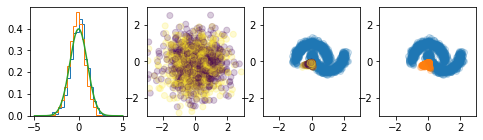

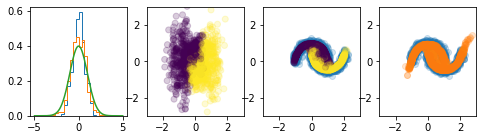

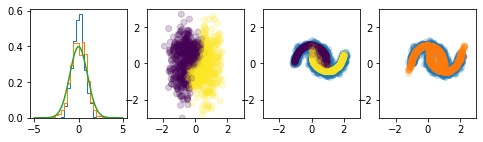

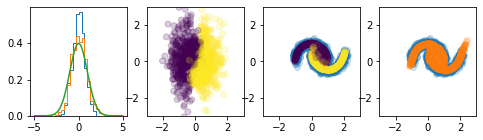

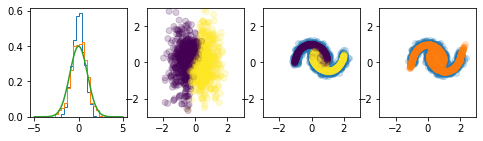

In [4]:
class VAE(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.latent_dim = 2
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(2,100),
            torch.nn.ReLU(),
            torch.nn.Linear(100,100),
            torch.nn.ReLU(),
            torch.nn.Linear(100,2*self.latent_dim)
        )
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(self.latent_dim,100),
            torch.nn.ReLU(),
            torch.nn.Linear(100,100),
            torch.nn.ReLU(),
            torch.nn.Linear(100,2)
        )   
        
    def forward(self, samples, eps):
        mean_logstd = self.encoder(samples)
        mean, log_std = mean_logstd[:,:self.latent_dim], mean_logstd[:,self.latent_dim:]
        latent = mean + eps * log_std.exp()
        return self.decoder(latent), latent, mean, log_std

def d_kl(mq,lsq):
    return -0.5*(1 + lsq  - mq.pow(2) - lsq.exp()).sum(axis=-1)
    
def elbo_loss(samples, reco, mean, log_std):
    reco_loss_fn = torch.nn.MSELoss()
    reco_loss = reco_loss_fn(samples,reco)/0.1
    dkl_loss = d_kl(mean, log_std)
    return (reco_loss + dkl_loss).mean()
    
def train_vae():
    model = VAE()
    opt = optim.Adam(model.parameters(),1e-3)

    for i in range(5000):
        model.zero_grad()
        samples,labels = sklearn.datasets.make_moons(1230, noise = 0.1)

        samples = torch.FloatTensor(samples)
        reco, latent, mean, log_std = model(samples,torch.randn((len(samples),model.latent_dim)))
        loss = elbo_loss(samples, reco, mean, log_std)
        loss.backward()
        opt.step()
        if i % 1000 == 0:
            plot_vae(samples,model,labels)
            plt.show()
    return model

model = train_vae()    

In [ ]:
def plot_vae(samples,model,labels):
    f,axarr = plt.subplots(1,4)
    with torch.no_grad():
        reco, latent, mean, log_std = model(samples,torch.randn((len(samples),model.latent_dim)))
        xi = np.linspace(-5,5,1001)
        yi = scipy.stats.norm.pdf(xi)
        axarr[0].hist(latent[:,0], bins = np.linspace(-5,5,31), density=True, histtype='step')
        axarr[0].hist(latent[:,1], bins = np.linspace(-5,5,31), density=True, histtype='step')
        axarr[0].plot(xi,yi)

        axarr[1].scatter(latent[:,0], latent[:,1], c = labels, alpha = 0.2)
        axarr[1].set_xlim(-3,3)
        axarr[1].set_ylim(-3,3)

        axarr[2].scatter(samples[:,0],samples[:,1], alpha = 0.2)
        axarr[2].scatter(reco[:,0],reco[:,1], alpha = 0.2, c = labels)
        axarr[2].set_xlim(-3,3)
        axarr[2].set_ylim(-3,3)


        latent = torch.randn((len(samples),model.latent_dim))
        reco = model.decoder(latent)
        axarr[3].scatter(samples[:,0],samples[:,1], alpha = 0.2)
        axarr[3].scatter(reco[:,0],reco[:,1], alpha = 0.2)
        axarr[3].set_xlim(-3,3)
        axarr[3].set_ylim(-3,3)

        
    f.set_size_inches(8,2)
    